In [1]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples
input_dim = mnist.train.images[0].shape[0]
w = h = int(np.sqrt(input_dim))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
class Autoencoder(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z = fc(f3, self.n_z, scope='enc_fc4', activation_fn=tf.nn.relu)

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.recon_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss
        }
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z    

In [4]:
def trainer(model_object, learning_rate=1e-4, 
            batch_size=64, num_epoch=100, n_z=16, log_step=5):
    model = model_object(
        learning_rate=learning_rate, batch_size=batch_size, n_z=n_z)

    for epoch in range(num_epoch):
        start_time = time.time()
        for iter in range(num_sample // batch_size):
            # Get a batch
            batch = mnist.train.next_batch(batch_size)
            # Execute the forward and backward pass 
            # Report computed losses
            losses = model.run_single_step(batch[0])
        end_time = time.time()
        
        if epoch % log_step == 0:
            log_str = '[Epoch {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}  '.format(k, v)
            log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
            print(log_str)
            
    print('Done!')
    return model

In [ ]:
# Train a model
model = trainer(Autoencoder)

[Epoch 0] recon_loss: 154.094  (1.920 sec/epoch)
[Epoch 5] recon_loss: 97.439  (1.865 sec/epoch)
[Epoch 10] recon_loss: 93.750  (1.898 sec/epoch)
[Epoch 15] recon_loss: 82.080  (1.910 sec/epoch)
[Epoch 20] recon_loss: 79.717  (1.994 sec/epoch)
[Epoch 25] recon_loss: 80.159  (1.875 sec/epoch)
[Epoch 30] recon_loss: 81.308  (1.957 sec/epoch)
[Epoch 35] recon_loss: 77.129  (1.730 sec/epoch)
[Epoch 40] recon_loss: 77.229  (1.831 sec/epoch)
[Epoch 45] recon_loss: 80.721  (1.739 sec/epoch)
[Epoch 50] recon_loss: 75.139  (1.927 sec/epoch)
[Epoch 55] recon_loss: 77.770  (1.990 sec/epoch)
[Epoch 60] recon_loss: 79.983  (1.770 sec/epoch)
[Epoch 65] recon_loss: 74.244  (1.858 sec/epoch)
[Epoch 70] recon_loss: 71.158  (1.780 sec/epoch)
[Epoch 75] recon_loss: 73.004  (2.044 sec/epoch)
[Epoch 80] recon_loss: 76.933  (1.995 sec/epoch)
[Epoch 85] recon_loss: 76.362  (1.936 sec/epoch)
[Epoch 90] recon_loss: 71.508  (1.994 sec/epoch)
[Epoch 95] recon_loss: 79.797  (1.787 sec/epoch)
Done!


In [ ]:
def test_reconstruction(model, mnist, h=28, w=28, batch_size=100):
    # Test the trained model: reconstruction
    batch = mnist.test.next_batch(batch_size)
    x_reconstructed = model.reconstructor(batch[0])

    n = np.sqrt(batch_size).astype(np.int32)
    I_reconstructed = np.empty((h*n, 2*w*n))
    for i in range(n):
        for j in range(n):
            x = np.concatenate(
                (x_reconstructed[i*n+j, :].reshape(h, w), 
                 batch[0][i*n+j, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

    plt.figure(figsize=(10, 20))
    plt.imshow(I_reconstructed, cmap='gray')

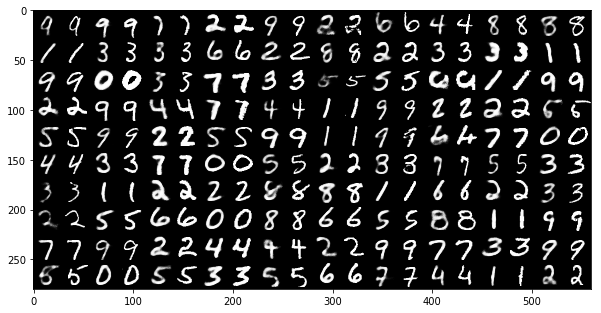

In [ ]:
test_reconstruction(model, mnist)

In [ ]:
# Train a model with 2d latent space
model_2d = trainer(Autoencoder, n_z=2)

[Epoch 0] recon_loss: 195.749  (1.888 sec/epoch)
[Epoch 5] recon_loss: 157.520  (1.898 sec/epoch)
[Epoch 10] recon_loss: 154.422  (1.737 sec/epoch)
[Epoch 15] recon_loss: 143.310  (1.992 sec/epoch)
[Epoch 20] recon_loss: 144.781  (1.785 sec/epoch)
[Epoch 25] recon_loss: 137.258  (2.018 sec/epoch)
[Epoch 30] recon_loss: 134.022  (1.848 sec/epoch)
[Epoch 35] recon_loss: 144.299  (2.158 sec/epoch)
[Epoch 40] recon_loss: 150.555  (1.984 sec/epoch)
[Epoch 45] recon_loss: 134.665  (2.152 sec/epoch)
[Epoch 50] recon_loss: 144.337  (1.647 sec/epoch)
[Epoch 55] recon_loss: 135.430  (1.963 sec/epoch)
[Epoch 60] recon_loss: 135.092  (1.973 sec/epoch)
[Epoch 65] recon_loss: 138.546  (2.023 sec/epoch)
[Epoch 70] recon_loss: 138.604  (1.920 sec/epoch)
[Epoch 75] recon_loss: 135.054  (2.025 sec/epoch)
[Epoch 80] recon_loss: 130.601  (2.058 sec/epoch)
[Epoch 85] recon_loss: 143.423  (1.845 sec/epoch)
[Epoch 90] recon_loss: 140.369  (2.001 sec/epoch)
[Epoch 95] recon_loss: 132.202  (1.849 sec/epoch)
Do

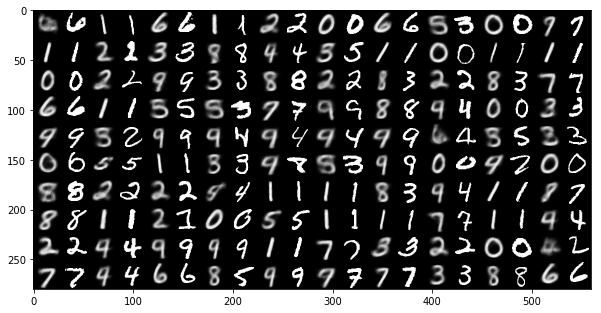

In [ ]:
test_reconstruction(model_2d, mnist)

In [ ]:
def test_transformation(model, mnist, batch_size=3000):
    # Test the trained model: transformation
    assert model.n_z == 2
    batch = mnist.test.next_batch(batch_size)
    z = model.transformer(batch[0])
    plt.figure(figsize=(10, 8)) 
    plt.scatter(z[:, 0], z[:, 1], c=np.argmax(batch[1], 1), s=20)
    plt.colorbar()
    plt.grid()

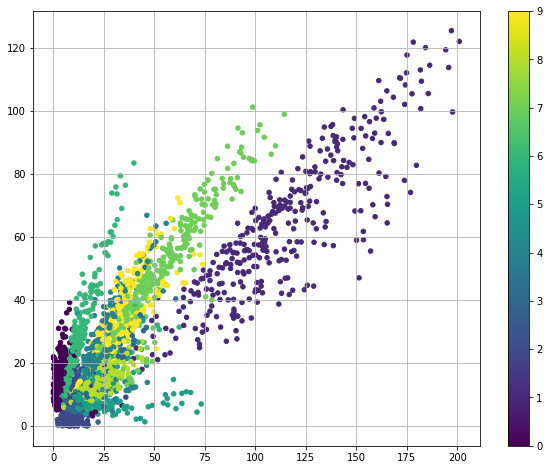

In [ ]:
test_transformation(model_2d, mnist)

In [ ]:
class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        tf.reset_default_graph()
        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', 
                       activation_fn=None)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma', 
                                 activation_fn=None)
        eps = tf.random_normal(
            shape=tf.shape(self.z_log_sigma_sq),
            mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # KL divergence: measure the difference between two distributions
        # Here we measure the divergence between 
        # the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - 
            tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = self.recon_loss + self.latent_loss
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
        }        
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [ ]:
# Train a model
model = trainer(VariantionalAutoencoder)

[Epoch 0] recon_loss: 181.388  total_loss: 186.534  latent_loss: 5.146  (2.518 sec/epoch)
[Epoch 5] recon_loss: 122.884  total_loss: 137.438  latent_loss: 14.554  (2.705 sec/epoch)
[Epoch 10] recon_loss: 104.469  total_loss: 123.041  latent_loss: 18.572  (2.472 sec/epoch)
[Epoch 15] recon_loss: 90.458  total_loss: 108.874  latent_loss: 18.416  (2.718 sec/epoch)
[Epoch 20] recon_loss: 96.444  total_loss: 116.219  latent_loss: 19.775  (2.482 sec/epoch)
[Epoch 25] recon_loss: 98.227  total_loss: 118.392  latent_loss: 20.165  (2.679 sec/epoch)
[Epoch 30] recon_loss: 93.491  total_loss: 114.682  latent_loss: 21.192  (2.605 sec/epoch)
[Epoch 35] recon_loss: 87.729  total_loss: 108.034  latent_loss: 20.305  (2.504 sec/epoch)
[Epoch 40] recon_loss: 86.310  total_loss: 106.389  latent_loss: 20.079  (2.475 sec/epoch)
[Epoch 45] recon_loss: 87.967  total_loss: 109.133  latent_loss: 21.166  (2.557 sec/epoch)
[Epoch 50] recon_loss: 84.997  total_loss: 105.153  latent_loss: 20.156  (2.255 sec/epoch)

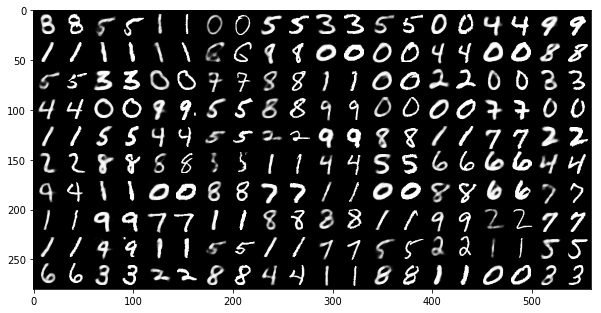

In [ ]:
test_reconstruction(model, mnist)

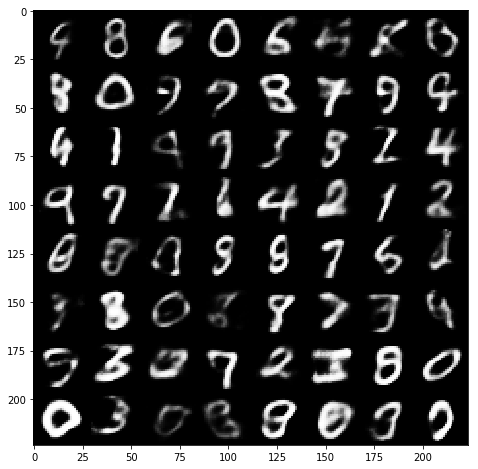

In [ ]:
# Test the trained model: generation
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[model.batch_size, model.n_z])
x_generated = model.generator(z)

n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(h, w)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated, cmap='gray')

In [ ]:
# Train a model with 2d latent space
model_2d = trainer(VariantionalAutoencoder, n_z=2)

[Epoch 0] recon_loss: 189.067  total_loss: 191.912  latent_loss: 2.845  (2.349 sec/epoch)
[Epoch 5] recon_loss: 163.223  total_loss: 168.518  latent_loss: 5.295  (2.487 sec/epoch)
[Epoch 10] recon_loss: 162.157  total_loss: 167.209  latent_loss: 5.052  (2.642 sec/epoch)
[Epoch 15] recon_loss: 162.713  total_loss: 168.023  latent_loss: 5.309  (2.370 sec/epoch)
[Epoch 20] recon_loss: 157.039  total_loss: 162.629  latent_loss: 5.590  (2.850 sec/epoch)
[Epoch 25] recon_loss: 143.972  total_loss: 149.832  latent_loss: 5.860  (2.555 sec/epoch)
[Epoch 30] recon_loss: 159.084  total_loss: 164.984  latent_loss: 5.899  (2.508 sec/epoch)
[Epoch 35] recon_loss: 145.006  total_loss: 150.825  latent_loss: 5.819  (2.585 sec/epoch)
[Epoch 40] recon_loss: 131.849  total_loss: 137.795  latent_loss: 5.946  (2.333 sec/epoch)
[Epoch 45] recon_loss: 142.673  total_loss: 148.976  latent_loss: 6.303  (2.503 sec/epoch)
[Epoch 50] recon_loss: 140.991  total_loss: 147.014  latent_loss: 6.024  (2.571 sec/epoch)
[

In [ ]:
test_transformation(model_2d, mnist)

In [ ]:
# Test the trained model: uniformly samlpe in the latent space
n = 20
x = np.linspace(-2, 2, n)
y = np.linspace(-2, 2, n)

I_latent = np.empty((h*n, w*n))
for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        z = np.array([[xi, yi]]*model_2d.batch_size)
        x_hat = model_2d.generator(z)
        I_latent[(n-i-1)*h:(n-i)*h, j*w:(j+1)*w] = x_hat[0].reshape(h, w)

plt.figure(figsize=(8, 8))        
plt.imshow(I_latent, cmap="gray")